In [1]:
import json
import os
import pickle
import psycopg2
import sqlalchemy
import sys
sys.path.append("..")

from connect_db import db_connection


import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns
#import pytess
get_ipython().magic(u'matplotlib inline')
%matplotlib inline

from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt ## this is a different name from atop??

from scipy.spatial import Voronoi, voronoi_plot_2d

username='ywang99587'

In [65]:
#cred_location = '/mnt/data/'+username+'/TPT/connect_db/data_creds.json.nogit'  ## changed to TPT
#db = db_connection.DBConnection(cred_location)

In [66]:
cred_location = '../connect_db/data_creds_redshift.json.nogit'  ## changed to TPT
db = db_connection.DBConnection(cred_location)

In [4]:
!pwd

/mnt/data/ywang99587/TPT/descriptives


In [3]:
query_feature = """select *
        from tpt.tuscany_test.customer_feature"""

In [4]:
df_feature = db.sql_query_to_data_frame(query_feature)
df_feature.head()
#df_feature.shape()

,customer_id,mcc,hrs_in_italy,hr_arvl_italy,day_of_wk_arvl_italy,mon_arvl_italy,day_arvl_italy,loc_arvl_italy,num_uniuqe_loc_in_italy,num_loc_in_italy,...,num_loc_in_tusc,hrs_in_tusc,hr_arvl_tusc,day_of_wk_arvl_tusc,mon_arvl_tusc,day_arvl_tusc,loc_arvl_tusc,hrs_outside_tuscany,locs_outside_tuscany,unique_locs_outside_tuscany
0,8E0C31A487E78B332D527A6C480191A6,440.0,52.0,7.0,2.0,5.0,2.0,3561547.0,95.0,120.0,...,60.0,46.0,9.0,2.0,5.0,2.0,3508951.0,6.0,60.0,59.0
1,937604197AFE06788EC62805EBD29240,204.0,129.0,13.0,1.0,5.0,1.0,59344032.0,86.0,263.0,...,263.0,129.0,13.0,1.0,5.0,1.0,59344032.0,0.0,0.0,0.0
2,F16E2EE53C12D90AFDAEC7CB67BCA014,310.0,23.0,0.0,1.0,5.0,1.0,3653231.0,70.0,132.0,...,33.0,9.0,0.0,1.0,5.0,1.0,3653231.0,14.0,99.0,52.0
3,1AA2A507A88DA7806C5516EBE32F227D,450.0,71.0,0.0,1.0,5.0,1.0,38116011.0,200.0,504.0,...,246.0,47.0,11.0,1.0,5.0,1.0,57080012.0,24.0,258.0,114.0
4,3C768BEAD11AA60702AAE809DDFE584E,262.0,45.0,0.0,1.0,5.0,1.0,3626537.0,124.0,373.0,...,262.0,43.0,0.0,1.0,5.0,1.0,3626537.0,2.0,111.0,86.0


In [5]:
df_feature.columns

Index(['customer_id', 'mcc', 'hrs_in_italy', 'hr_arvl_italy',
       'day_of_wk_arvl_italy', 'mon_arvl_italy', 'day_arvl_italy',
       'loc_arvl_italy', 'num_uniuqe_loc_in_italy', 'num_loc_in_italy',
       'num_uniuqe_loc_in_tusc', 'num_loc_in_tusc', 'hrs_in_tusc',
       'hr_arvl_tusc', 'day_of_wk_arvl_tusc', 'mon_arvl_tusc', 'day_arvl_tusc',
       'loc_arvl_tusc', 'hrs_outside_tuscany', 'locs_outside_tuscany',
       'unique_locs_outside_tuscany'],
      dtype='object')

In [37]:
df_feature2 = df_feature[['hrs_in_italy', 
       'day_of_wk_arvl_italy', 
        'num_uniuqe_loc_in_italy', 'num_loc_in_italy','num_uniuqe_loc_in_tusc', 'num_loc_in_tusc', 'hrs_in_tusc',
        'day_of_wk_arvl_tusc']]

df_feature2.corr()

,hrs_in_italy,day_of_wk_arvl_italy,num_uniuqe_loc_in_italy,num_loc_in_italy,num_uniuqe_loc_in_tusc,num_loc_in_tusc,hrs_in_tusc,day_of_wk_arvl_tusc
hrs_in_italy,1.000000,-0.210544,0.388632,0.469475,0.492480,0.489128,0.988533,-0.210544
day_of_wk_arvl_italy,-0.210544,1.000000,-0.029244,-0.071763,-0.071682,-0.094312,-0.221538,1.000000
num_uniuqe_loc_in_italy,0.388632,-0.029244,1.000000,0.722733,0.825764,0.521208,0.323460,-0.029244
num_loc_in_italy,0.469475,-0.071763,0.722733,1.000000,0.707330,0.911765,0.433157,-0.071763
num_uniuqe_loc_in_tusc,0.492480,-0.071682,0.825764,0.707330,1.000000,0.685028,0.465778,-0.071682
num_loc_in_tusc,0.489128,-0.094312,0.521208,0.911765,0.685028,1.000000,0.482361,-0.094312
hrs_in_tusc,0.988533,-0.221538,0.323460,0.433157,0.465778,0.482361,1.000000,-0.221538
day_of_wk_arvl_tusc,-0.210544,1.000000,-0.029244,-0.071763,-0.071682,-0.094312,-0.221538,1.000000


In [38]:
df_feature2.shape

(358503, 8)

In [39]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
#from sklearn.preprocessing import scale

#kmeans = KMeans(n_clusters=20)
#kmeans.fit(df_feature)

#Nc = range(1, 20)

#kmeans = [KMeans(n_clusters=i) for i in Nc]
#[kmeans[i].fit(df_feature) for i in range(len(kmeans))]
#kmeans

#score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

#score

In [40]:
pca=PCA(n_components=5)
pca.fit(df_feature2)
print(pca.explained_variance_ratio_) 

[0.90787625 0.0493841  0.02831324 0.01290459 0.00131921]


In [46]:
reduced_feature = PCA(n_components=2).fit_transform(df_feature2)
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
output=kmeans.fit(reduced_feature)

In [42]:
kmeans.cluster_centers_

array([[ 9.27557529e+02,  3.98287615e+00],
       [-6.91309582e+01, -2.96844170e-01]])

In [ ]:
plt.scatter(reduced_feature[:,0], reduced_feature[:,1], c=output.labels_)

In [31]:
kmeans = KMeans(n_clusters=2) 
kmeans.fit(df_feature2) 
kmeans.cluster_centers_

array([[ 35.51415394,   2.59039727,  35.96583512,  78.70943165,
         17.87773645,  45.96481586,  30.80035359,   2.59039727,
         32.74461579,  18.08809867],
       [103.39571594,   2.10667696, 176.23211115, 835.84330374,
        104.07333076, 632.32053261,  96.00578927,   2.10667696,
        203.52277113,  72.15878039]])

In [32]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]
[kmeans[i].fit(df_feature2) for i in range(len(kmeans))]


[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=1, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max

In [33]:
labels = [kmeans[i].predict(df_feature2) for i in range(len(kmeans))]


In [34]:
labels = [kmeans[i].predict(df_feature2) for i in range(len(kmeans))]
#centroids = kmeans.cluster_centers_
#metrics.silhouette_score(df_feature, labels, metric='euclidean')
sl_score = [metrics.silhouette_score(df_feature2, labels[i], metric='euclidean') for i in range(1, 18)]
#len(labels)
#metrics.silhouette_score(df_feature, labels[1], metric='euclidean')
#len(kmeans)
sl_score


MemoryError: 

In [35]:
import pylab as pl

pl.plot(range(1,18), sl_score)

NameError: name 'sl_score' is not defined

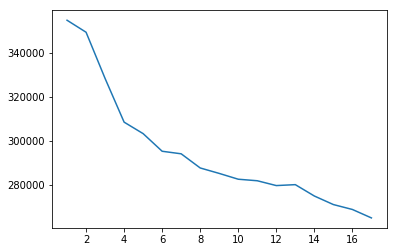

In [36]:
import pylab as pl
ch_score = [metrics.calinski_harabaz_score(df_feature2, labels[i]) for i in range(1,18)]
pl.plot(range(1,18), ch_score)

In [27]:
metrics.calinski_harabaz_score(df_feature, labels)

9375.10285805363

In [ ]:
# k means determine k use distortion?
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_feature)
    kmeanModel.fit(df_feature)
    distortions.append(sum(np.min(cdist(df_feature, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_feature.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [24]:
query = """select * from dblink('foreign_server',$REDSHIFT$ tpt.tuscany_test.vodafone $REDSHIFT$)
limit 1000""" ## only subset

In [25]:
data = db.sql_query_to_data_frame(query)
data.head()

OperationalError: (psycopg2.OperationalError) FATAL:  password authentication failed for user "dbu"
FATAL:  password authentication failed for user "dbu"
 (Background on this error at: http://sqlalche.me/e/e3q8)

In [101]:
query_lonlat = """select loc.location_id, loc.lat, loc.lon, dic.region
from tpt.tuscany.location as loc
inner join  tpt.tuscany.location_dictionary as dic
on dic.location_id=loc.location_id
where dic.region = 9"""

In [102]:
locations = db.sql_query_to_data_frame(query_lonlat, cust_id=True)

Index(['location_id', 'lat', 'lon', 'region'], dtype='object')
Index(['location_id', 'lat', 'lon', 'region'], dtype='object')
{'location_id': <class 'float'>, 'lat': <class 'numpy.float64'>, 'lon': <class 'numpy.float64'>, 'region': <class 'float'>}
Index(['location_id', 'lat', 'lon', 'region'], dtype='object')


In [103]:
locations.head()

,location_id,lat,lon,region
0,3651354.0,43.8651,10.2603,9.0
1,3651726.0,43.7011,10.7488,9.0
2,56213032.0,43.3509,10.4625,9.0
3,3657207.0,43.7958,11.2023,9.0
4,3655521.0,43.8728,10.2729,9.0


In [104]:
k=zip(list(locations.lat), list(locations.lon))
new_points=[]
for i in list(k):
    #print(i)
    y=[i[1], i[0]]
    #if y not in new_points:
    new_points.append(y)

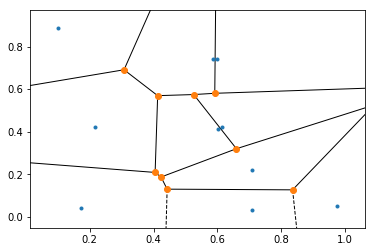

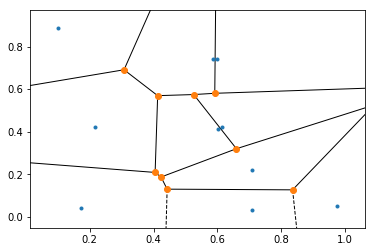

In [77]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely.geometry
import shapely.ops

points = np.random.random((10, 2))
vor = Voronoi(points)
voronoi_plot_2d(vor)

In [87]:
vor = Voronoi(new_points)

In [135]:
vor.max_bound

array([18.406 , 46.6042])

In [136]:
vor.min_bound

array([ 6.933 , 35.5292])

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


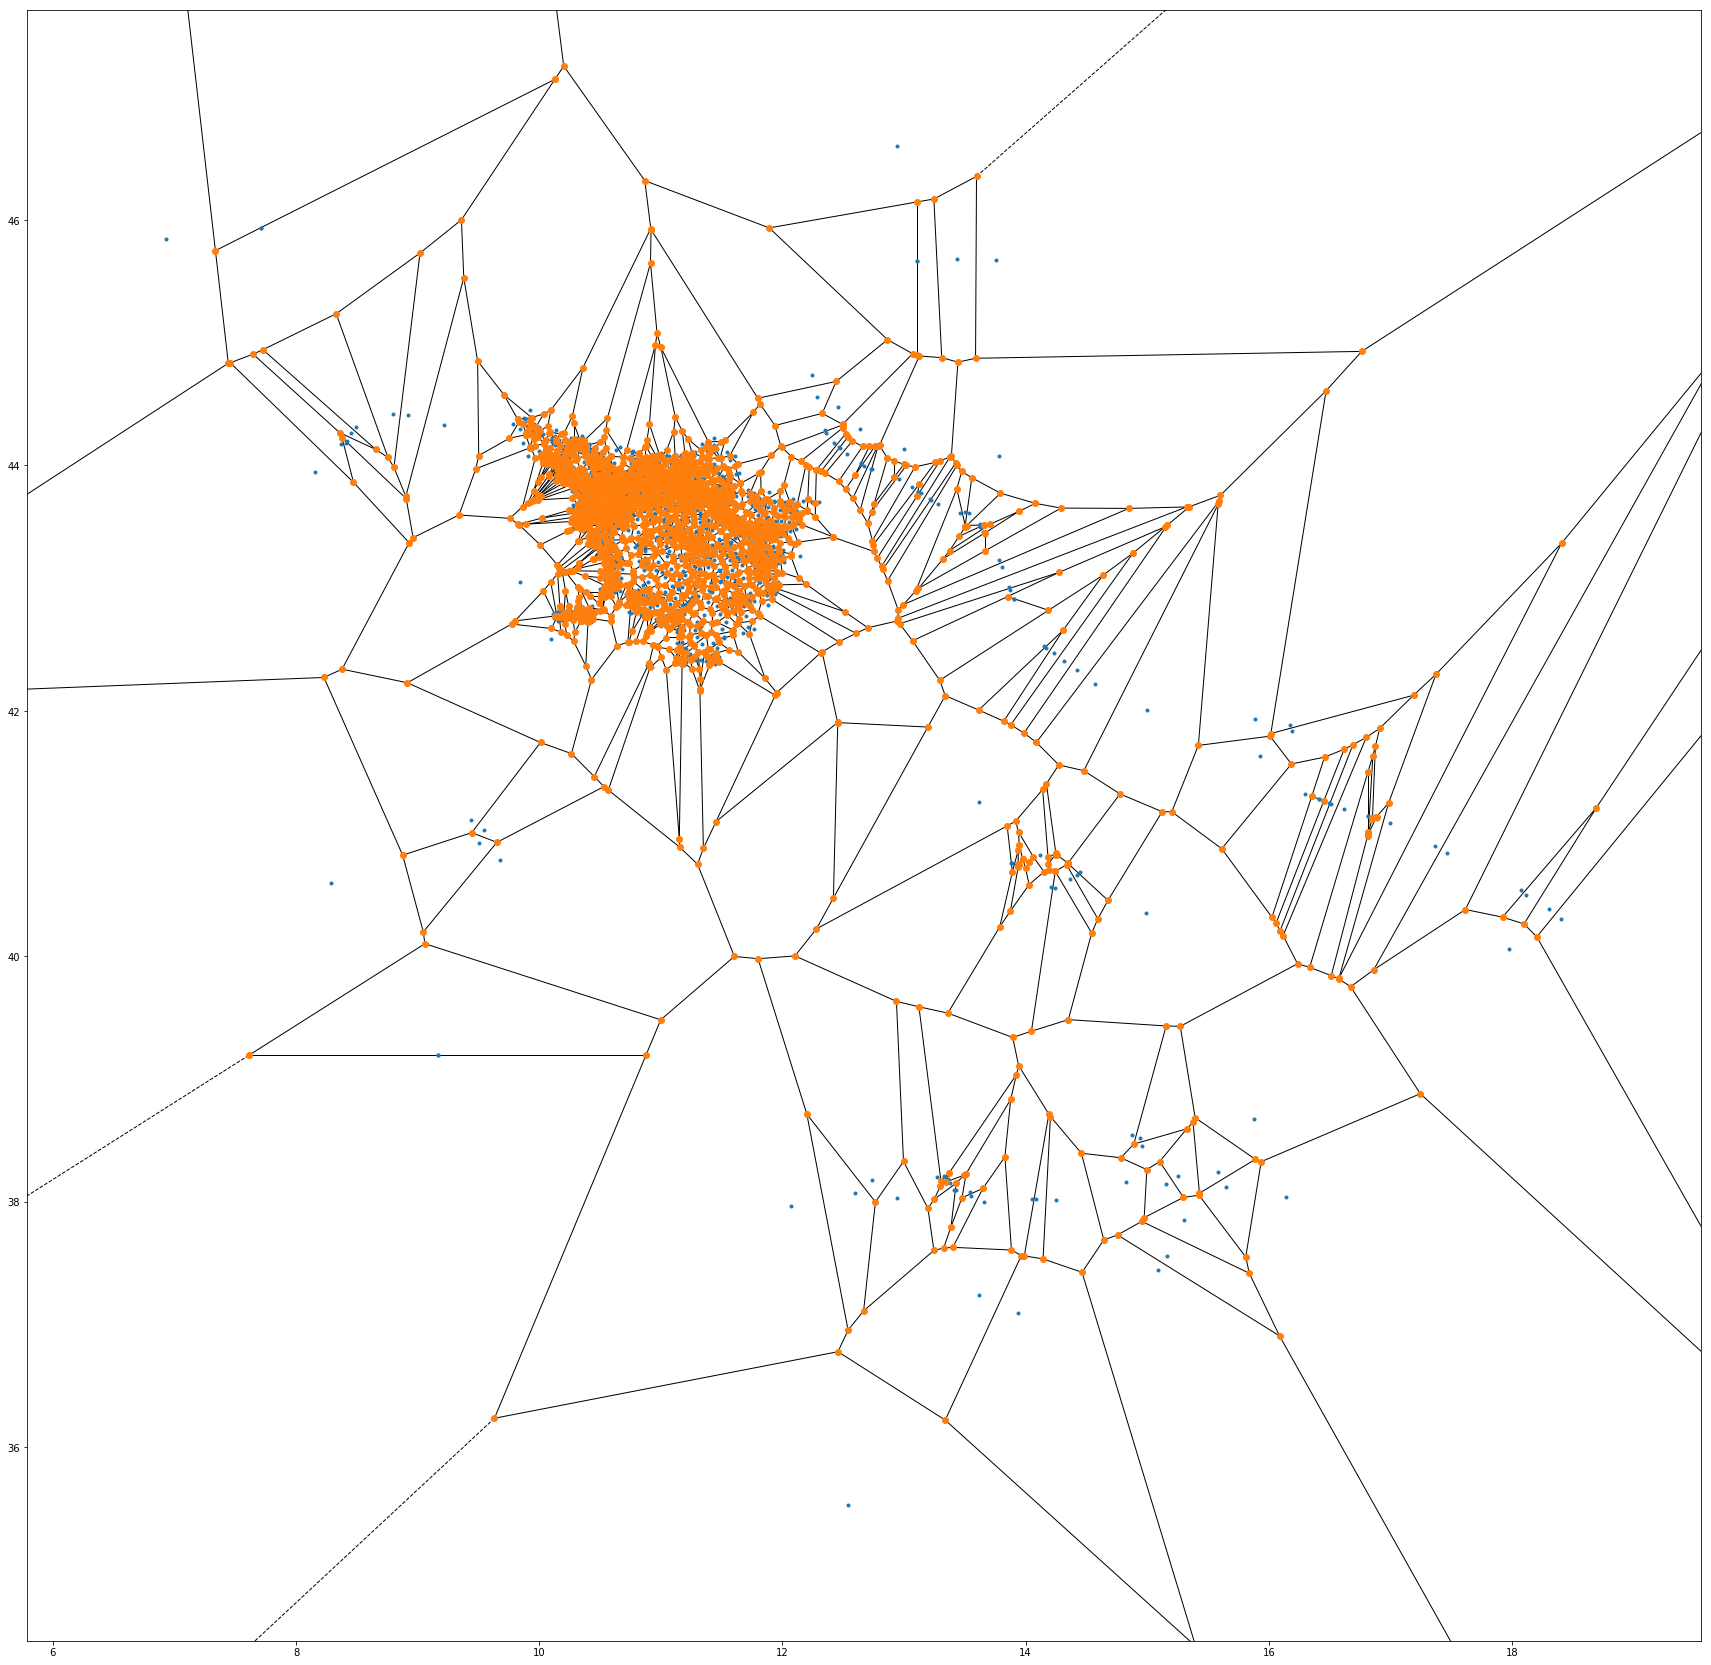

In [105]:
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
fig.set_size_inches(30, 30)
fig.show()

In [137]:
lines = [
    shapely.geometry.LineString(vor.vertices[line])
    for line in vor.ridge_vertices]

In [138]:
len(lines)

5056

In [139]:
a=[]
for poly in shapely.ops.polygonize(lines):
    a.append(gpd.GeoSeries(poly))

In [140]:
vors=gpd.GeoDataFrame(a).rename(columns={0:"geometry"})

In [143]:
vors['geometry'].describe()

Exception ignored in: <bound method BaseGeometry.__del__ of <shapely.geometry.polygon.LinearRing object at 0x7fb4d0b7cbe0>>
Traceback (most recent call last):
  File "/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/shapely/geometry/base.py", line 233, in __del__
    def __del__(self):
KeyboardInterrupt


count                                                  1676
unique                                                 1676
top       POLYGON ((10.58074190613628 43.68886210942402,...
freq                                                      1
Name: geometry, dtype: object

In [144]:
#vors.to_crs(epsg=4326)

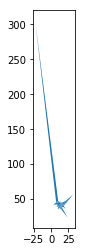

In [120]:
crs = {'init': 'epsg:4326'}

In [81]:
## turn to spatial points

geometry = [Point(xy) for xy in zip(locations.lon, locations.lat)]
locations = locations.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_locations = GeoDataFrame(locations, crs=crs, geometry=geometry)
geo_locations.head()

,location_id,region,geometry
0,3651354.0,9.0,POINT (10.2603 43.8651)
1,3651726.0,9.0,POINT (10.7488 43.7011)
2,56213032.0,9.0,POINT (10.4625 43.3509)
3,3657207.0,9.0,POINT (11.2023 43.7958)
4,3655521.0,9.0,POINT (10.2729 43.8728)


In [ ]:
data_loc = 

In [11]:
data_cus = data.groupby(['customer_id'])
data_cus.head()
#test=data_cus.get_group([1])
data_cus.dtypes

,location_id,mcc,time_stamp
customer_id,,,
1B258596DED83D5C08F1CAE80120A9B2,NaN,NaN,NaN
4BE344DEB295050AE49716747F9EA2B8,NaN,NaN,NaN
63143941BA35A71AA68698FC3100E833,NaN,NaN,NaN
654FC3D1EDD57FA7881E655C29AB8BDE,NaN,NaN,NaN
8E0C31A487E78B332D527A6C480191A6,NaN,NaN,NaN
8E8101CE2DD7BC3509D43D0052D8EBA6,NaN,NaN,NaN
9BC72F8DB9D2424E30410D456BDB2BE3,NaN,NaN,NaN
ADEFC5074300EC29BF93C0610F39B1CD,NaN,NaN,NaN
DEE7C2245BABC954EC8A2AF9F6AD6D85,NaN,NaN,NaN


In [ ]:
query_country = """select distinct mcc, count(distinct customer_id) from tpt.tuscany_test.vodafone group by mcc 
order by count(distinct customer_id) desc"""

In [5]:
data_country = db.sql_query_to_data_frame(query_country)

In [6]:
mcc_country = pd.read_csv('/mnt/data/shared/mcc-mnc-table.csv')
mcc_country.head()

,MCC,MCC (int),MNC,MNC (int),ISO,Country,Country Code,Network
0,289,649,88.0,2191,ge,Abkhazia,7.0,A-Mobile
1,289,649,68.0,1679,ge,Abkhazia,7.0,A-Mobile
2,289,649,67.0,1663,ge,Abkhazia,7.0,Aquafon
3,412,1042,88.0,2191,af,Afghanistan,93.0,Afghan Telecom Corp. (AT)
4,412,1042,80.0,2063,af,Afghanistan,93.0,Afghan Telecom Corp. (AT)


In [7]:
query_duration = """select distinct customer_id, min(time_stamp) as starttime, max(time_stamp) as endtime,
max(time_stamp)-min(time_stamp) as duration from tpt.tuscany_test.vodafone group by customer_id 
order by max(time_stamp)-min(time_stamp) desc"""

In [8]:
query_duration_tus = """select distinct customer_id, mcc, min(cur_time_stamp) as starttime, 
max(cur_time_stamp) as endtime, max(cur_time_stamp)-min(cur_time_stamp) as duration 
from tpt.tuscany_test.vodafone_trunc 
group by customer_id, mcc 
order by max(cur_time_stamp)-min(cur_time_stamp) desc"""

In [9]:
data_duration = db.sql_query_to_data_frame(query_duration_tus)  ## duration only in Tuscany

In [36]:
data_duration.duration.describe()

count                    357614
mean     1 days 10:21:33.050048
std      1 days 21:41:30.342948
min             0 days 00:00:00
25%             0 days 00:03:00
50%             0 days 11:48:00
75%             2 days 04:44:00
max             6 days 23:59:00
Name: duration, dtype: object

In [39]:
data_duration.head()
#data_duration.dtypes

,customer_id,mcc,starttime,endtime,duration
0,0C982B4BBDA2FF6DE67C6A8032EE7796,204.0,2017-05-01,2017-05-07 23:59:00,6 days 23:59:00
1,0F561EF3F065140486713F240D06AC5E,234.0,2017-05-01,2017-05-07 23:59:00,6 days 23:59:00
2,25EA4E81AC6AAAEE27FA7AC6E2C57A83,214.0,2017-05-01,2017-05-07 23:59:00,6 days 23:59:00
3,2A97C5AC4781B1EA32C29DE34F78C4C7,204.0,2017-05-01,2017-05-07 23:59:00,6 days 23:59:00
4,3DAE7EB6066E55B0D5F3C6BF82AF4A6C,262.0,2017-05-01,2017-05-07 23:59:00,6 days 23:59:00


In [10]:
zerotime = data_duration[data_duration['duration']==pd.Timedelta(0)]

In [11]:
query_zero_loc = """with duration as (
	select distinct customer_id, mcc,  min(time_stamp) as starttime, max(time_stamp) as endtime,
		max(time_stamp)-min(time_stamp) as duration from tpt.tuscany_test.vodafone group by customer_id, mcc
		order by max(time_stamp)-min(time_stamp) desc
),
duration_detail as (
select *, 
	extract(minute from duration) as minute, extract(hour from duration) as hour, 
	extract(day from duration) as day from duration 
),
zero_duration as (
	select * from duration_detail where minute=0 and hour=0 and day=0
),
location_back as (
	select z.*, v.* from
		zero_duration as z inner join tuscany_test.vodafone as v using(customer_id))
select * from location_back left join tuscany_test.location using (location_id) """

In [12]:
query_1hr_loc = """with duration as (
	select distinct customer_id, mcc,  min(time_stamp) as starttime, max(time_stamp) as endtime,
		max(time_stamp)-min(time_stamp) as duration from tpt.tuscany_test.vodafone group by customer_id, mcc
		order by max(time_stamp)-min(time_stamp) desc
),
duration_detail as (
select *, 
	extract(minute from duration) as minute, extract(hour from duration) as hour, 
	extract(day from duration) as day from duration 
),
zero_duration as (
	select * from duration_detail where day=0 and hour<1 
),
location_back as (
	select z.*, v.* from
		zero_duration as z inner join tuscany_test.vodafone as v using(customer_id))
select * from location_back left join tuscany_test.location using (location_id) """

In [13]:
zero_with_loc = db.sql_query_to_data_frame(query_zero_loc)

In [9]:
zero_with_loc.head()

,location_id,customer_id,mcc,starttime,endtime,duration,minute,hour,day,customer_id,mcc,time_stamp,lat,lon,geom
0,59315011.0,DCD44173427747DA244CBE7CB2610E70,460.0,2017-05-01 11:15:00,2017-05-01 11:15:00,0 days,0.0,0.0,0.0,DCD44173427747DA244CBE7CB2610E70,460.0,2017-05-01 11:15:00,43.2213,11.9207,0101000020E6100000BADA8AFD65D727406A4DF38E539C...
1,3025521.0,6FAAD27C7EF462A4129B9665B73DE56E,204.0,2017-05-04 17:00:00,2017-05-04 17:00:00,0 days,0.0,0.0,0.0,6FAAD27C7EF462A4129B9665B73DE56E,204.0,2017-05-04 17:00:00,43.4030,10.8738,0101000020E6100000567DAEB662BF2540DD24068195B3...
2,3652181.0,D545FDB1E890CCDE40C5FF695E18D3F2,450.0,2017-05-03 13:53:00,2017-05-03 13:53:00,0 days,0.0,0.0,0.0,D545FDB1E890CCDE40C5FF695E18D3F2,450.0,2017-05-03 13:53:00,43.7696,11.2597,0101000020E6100000DB8AFD65F78426403480B74082E2...
3,57021031.0,D42B35BEE81169F8C52016F7DAAC50D1,206.0,2017-05-01 16:25:00,2017-05-01 16:25:00,0 days,0.0,0.0,0.0,D42B35BEE81169F8C52016F7DAAC50D1,206.0,2017-05-01 16:25:00,43.8707,10.2435,0101000020E6100000E9263108AC7C24404850FC1873EF...
4,3640178.0,671E9E906BB346A0E314EB0EAF49DC13,710.0,2017-05-07 09:36:00,2017-05-07 09:36:00,0 days,0.0,0.0,0.0,671E9E906BB346A0E314EB0EAF49DC13,710.0,2017-05-07 09:36:00,42.7514,10.2094,0101000020E610000097900F7A366B2440711B0DE02D60...


In [14]:
oneHr_with_loc = db.sql_query_to_data_frame(query_1hr_loc)

In [15]:
oneHr_with_loc.head()

,location_id,customer_id,mcc,starttime,endtime,duration,minute,hour,day,customer_id,mcc,time_stamp,lat,lon,geom,geom_transformed
0,59945033.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:28:00,43.7690,11.2954,0101000020430D0000107A36AB3E972640DF4F8D976EE2...,0101000020430D0000107A36AB3E972640DF4F8D976EE2...
1,59945033.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:32:00,43.7690,11.2954,0101000020430D0000107A36AB3E972640DF4F8D976EE2...,0101000020430D0000107A36AB3E972640DF4F8D976EE2...
2,59945033.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:29:00,43.7690,11.2954,0101000020430D0000107A36AB3E972640DF4F8D976EE2...,0101000020430D0000107A36AB3E972640DF4F8D976EE2...
3,59945033.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:31:00,43.7690,11.2954,0101000020430D0000107A36AB3E972640DF4F8D976EE2...,0101000020430D0000107A36AB3E972640DF4F8D976EE2...
4,59897012.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,43.7922,11.2429,0101000020430D0000956588635D7C264013F241CF66E5...,0101000020430D0000956588635D7C264013F241CF66E5...


In [2]:
# load data from TPT 
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"

In [3]:

# Select only Tuscany# Selec 
df = gpd.read_file(provinces)
df_mun = gpd.read_file(municipalities)
df_tusc = df[df["COD_REG"] == 9]   #tuscany
df_mun_tusc = df_mun[df_mun["COD_REG"] == 9]

# Convert coordinates in WGS84 to Lat Lon format (DO NOT use for the _github files)
# see http://geopandas.org/projections.html
df_tusc['geometry'] = df_tusc['geometry'].to_crs(epsg=4326)
df_mun_tusc['geometry'] = df_mun_tusc['geometry'].to_crs(epsg=4326)

# Color code for the plot (if necesary)
df_tusc["color_code"] = df_tusc["COD_PRO"].astype("str")

df_tusc.PROVINCIA.unique()

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

array(['Pistoia', '-', 'Massa Carrara', 'Lucca', 'Arezzo', 'Livorno',
       'Pisa', 'Grosseto', 'Siena', 'Prato'], dtype=object)

In [5]:
len(df_mun_tusc)

279

In [18]:
top_cities = pd.read_csv('/mnt/data/shared/important_cities.csv')
top_cities.head()

,city,lat,long
0,Siena,43.3188,11.3308
1,Pisa,43.7228,10.4017
2,Florence,43.7696,11.2558
3,Lucca,43.8376,10.4951
4,Arezzo,43.4633,11.8796


In [19]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt ## this is a different name from atop??

geometry = [Point(xy) for xy in zip(top_cities.long, top_cities.lat)]
top_cities = top_cities.drop(['long', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_top_cities = GeoDataFrame(top_cities, crs=crs, geometry=geometry)
geo_top_cities.head()

,city,geometry
0,Siena,POINT (11.3308 43.3188)
1,Pisa,POINT (10.4017 43.7228)
2,Florence,POINT (11.2558 43.7696)
3,Lucca,POINT (10.4951 43.8376)
4,Arezzo,POINT (11.8796 43.4633)


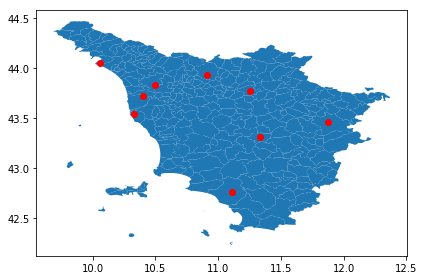

In [21]:
fig, ax = plt.subplots()
df_mun_tusc_sub.plot(ax=ax, figsize=(15, 15));
geo_top_cities.plot(ax=ax, color='red');
plt.tight_layout();

In [5]:
murlo = df_mun_tusc[df_mun_tusc['COMUNE']=='Murlo']
murlo.head()

,COD_REG,COD_CM,COD_PRO,PRO_COM,COMUNE,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,geometry
4523,9,0,52,52019,Murlo,None,2,49374.475787,1.156200e+08,"POLYGON ((11.29747576810991 43.22059368929922,..."


In [4]:
dist_comu = pd.read_csv('/mnt/data/ywang99587/TPT/comuni2district.csv')
dist_comu.Comuni=dist_comu.Comuni.str.title()
df_mun_tusc.COMUNE = df_mun_tusc.COMUNE.str.title()
dist_comu.head()
df_mun_tusc.head()
#len(dist_comu)

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,COD_REG,COD_CM,COD_PRO,PRO_COM,COMUNE,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,geometry
2184,9,0,50,50016,Lajatico,None,2,39199.763314,7.252656e+07,"POLYGON ((10.75725850757208 43.47990303453548,..."
2185,9,0,50,50019,Montecatini Val Di Cecina,None,2,71021.435967,1.542667e+08,"POLYGON ((10.77254200862866 43.42365277295023,..."
2186,9,0,50,50020,Montescudaio,None,2,25538.086490,2.017442e+07,"POLYGON ((10.64102154803947 43.33880682470539,..."
2187,9,0,50,50021,Monteverdi Marittimo,None,2,51146.528938,9.868594e+07,"POLYGON ((10.69120090373722 43.2465827944206, ..."
2188,9,0,50,50022,Montopoli In Val D'Arno,None,2,22016.003189,3.055075e+07,"POLYGON ((10.73668350705951 43.69451207336846,..."


In [5]:
df_mun_tusc_sub = df_mun_tusc[df_mun_tusc['COMUNE'].isin(dist_comu.Comuni)]
len(df_mun_tusc_sub)


279

In [6]:
#df_mun_tusc_sub
#len(df_mun_tusc_sub)
dist_comu_sub = dist_comu[dist_comu['Comuni'].isin(df_mun_tusc.COMUNE)]
len(dist_comu_sub) ## need to ask why the two islands are double-counted

281

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/geopandas/plotting.py:381: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


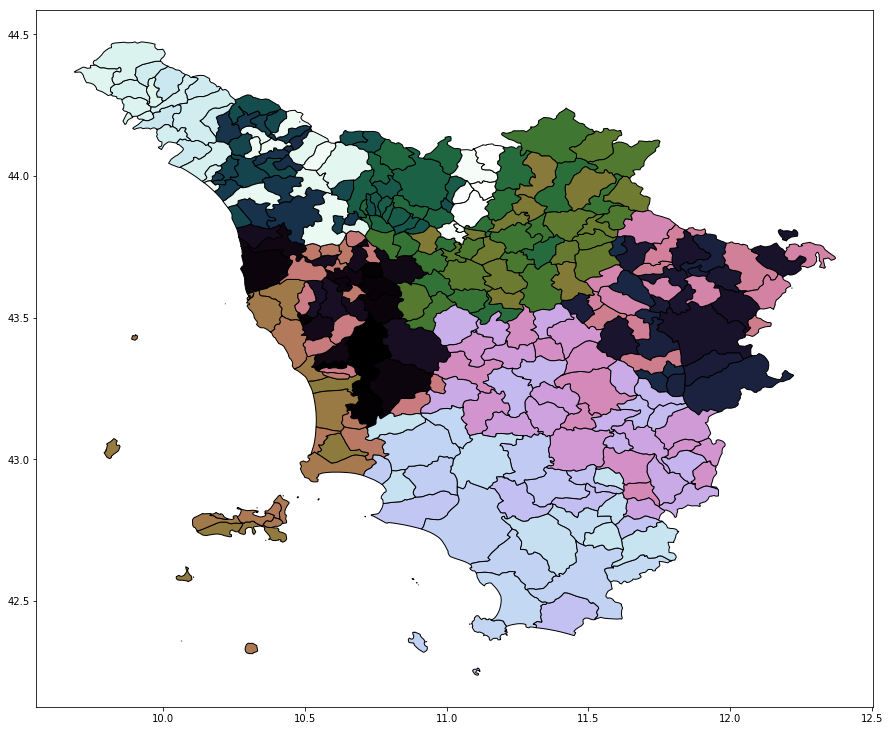

In [15]:
df_mun_tusc_sub.plot(colormap='cubehelix', edgecolor='k', figsize=(15, 15), alpha=1) 

In [7]:
df_mun_tusc_sub_dis = df_mun_tusc_sub.set_index('COMUNE').join(dist_comu.set_index('Comuni'), how='left')
df_mun_tusc_sub_dis.head()

,COD_REG,COD_CM,COD_PRO,PRO_COM,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,geometry,District
Abbadia San Salvatore,9,0,52,52001,None,2,38006.044646,5.890205e+07,"POLYGON ((11.72017904058687 42.91662784897439,...",Amiata
Abetone,9,0,47,47001,None,2,24193.101159,3.106125e+07,"POLYGON ((10.64458403465717 44.15975052540512,...",Pistoia.e.Montagna.Pistoiese
Agliana,9,0,47,47002,None,2,14875.427105,1.190028e+07,"POLYGON ((11.00795709538869 43.91038980836479,...",Pistoia.e.Montagna.Pistoiese
Altopascio,9,0,46,46001,None,2,26469.781524,2.883990e+07,"POLYGON ((10.68728416192193 43.84799004093083,...",Piana.di.Lucca
Anghiari,9,0,51,51001,None,2,63547.739772,1.306390e+08,"POLYGON ((11.95123247704638 43.61256210441386,...",Valtiberina.Toscana


In [8]:
df_dist = df_mun_tusc_sub_dis.dissolve(by='District')
df_dist.head()

,geometry,COD_REG,COD_CM,COD_PRO,PRO_COM,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area
District,,,,,,,,,
Amiata,"POLYGON ((11.74601766829812 42.78575944027563,...",9,0,52,52001,None,2,38006.044646,5.890205e+07
Arca.Pratese,"POLYGON ((11.06212465088694 43.81639246129403,...",9,0,100,100001,None,2,49741.081267,9.558182e+07
Arezzo,"POLYGON ((11.86421691033788 43.55692961358602,...",9,0,51,51002,None,2,112025.299215,3.837878e+08
Casentino,"POLYGON ((11.91829455961145 43.64376805671598,...",9,0,51,51004,None,2,49631.051762,8.767509e+07
Chianti,"POLYGON ((11.43587719650668 43.51161383763251,...",9,248,48,48003,None,1,57584.104550,6.760215e+07


In [9]:
df_dist['District'] = df_dist.index
df_dist['rown']=list(range(1,len(df_dist)+1))

In [10]:
df_dist.head()

,geometry,COD_REG,COD_CM,COD_PRO,PRO_COM,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,District,rown
District,,,,,,,,,,,
Amiata,"POLYGON ((11.74601766829812 42.78575944027563,...",9,0,52,52001,None,2,38006.044646,5.890205e+07,Amiata,1
Arca.Pratese,"POLYGON ((11.06212465088694 43.81639246129403,...",9,0,100,100001,None,2,49741.081267,9.558182e+07,Arca.Pratese,2
Arezzo,"POLYGON ((11.86421691033788 43.55692961358602,...",9,0,51,51002,None,2,112025.299215,3.837878e+08,Arezzo,3
Casentino,"POLYGON ((11.91829455961145 43.64376805671598,...",9,0,51,51004,None,2,49631.051762,8.767509e+07,Casentino,4
Chianti,"POLYGON ((11.43587719650668 43.51161383763251,...",9,248,48,48003,None,1,57584.104550,6.760215e+07,Chianti,5


In [11]:
df_mun_tusc_sub_dis.merge(df_dist[['District', 'rown']], on='District' )[['PRO_COM','rown']].to_csv('/mnt/data/shared/com_conv_to_district.csv', index=False)

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/geopandas/geodataframe.py:418: FutureWarning: 'District' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = DataFrame.merge(self, *args, **kwargs)


In [52]:
! head /mnt/data/shared/com_conv_to_district.csv

PRO_COM,rown
52001,1
53001,1
53004,1
53005,1
52020,1
53020,1
53022,1
53025,1
47001,17


In [77]:
len(df_dist)
df_dist.dtypes
df_dist.to_file('/mnt/data/shared/ITA_shapefiles/Tus_28districts.shp')

In [12]:
df_dist['District'] = df_dist.index


In [28]:
df_dist.head()

,geometry,COD_REG,COD_CM,COD_PRO,PRO_COM,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,District
District,,,,,,,,,,
Amiata,"POLYGON ((11.74601766829812 42.78575944027563,...",9,0,52,52001,None,2,38006.044646,5.890205e+07,Amiata
Arca.Pratese,"POLYGON ((11.06212465088694 43.81639246129403,...",9,0,100,100001,None,2,49741.081267,9.558182e+07,Arca.Pratese
Arezzo,"POLYGON ((11.86421691033788 43.55692961358602,...",9,0,51,51002,None,2,112025.299215,3.837878e+08,Arezzo
Casentino,"POLYGON ((11.91829455961145 43.64376805671598,...",9,0,51,51004,None,2,49631.051762,8.767509e+07,Casentino
Chianti,"POLYGON ((11.43587719650668 43.51161383763251,...",9,248,48,48003,None,1,57584.104550,6.760215e+07,Chianti


In [13]:
df_mun_tusc_sub_dis['District'] == df_dist['District']

ValueError: Can only compare identically-labeled Series objects

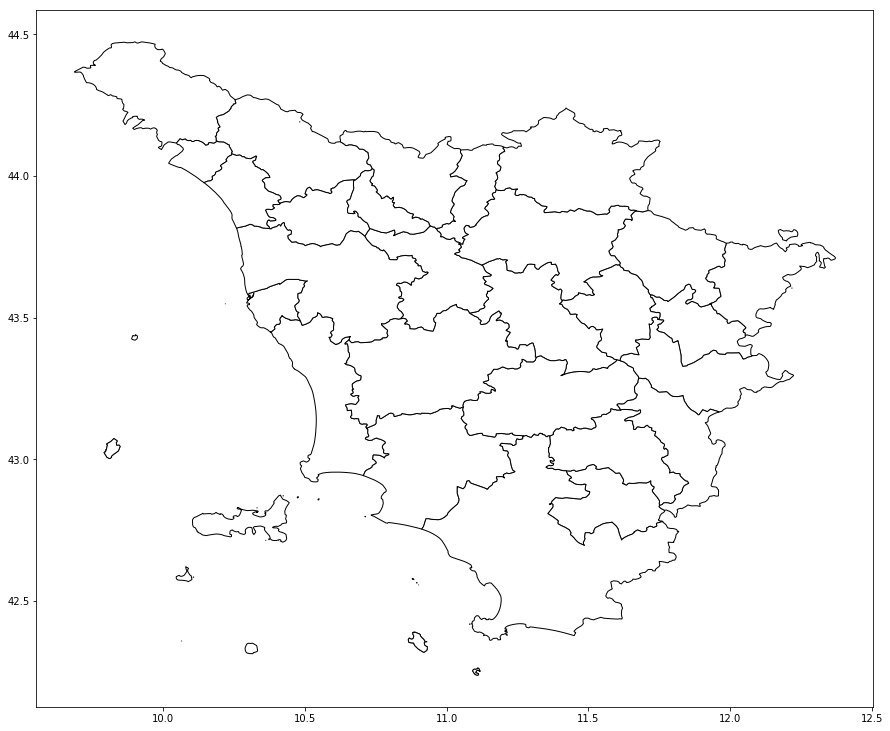

In [16]:
df_dist.plot(color='white', edgecolor='k', figsize=(15, 15), alpha=1) # only borders  colormap='cubehelix',


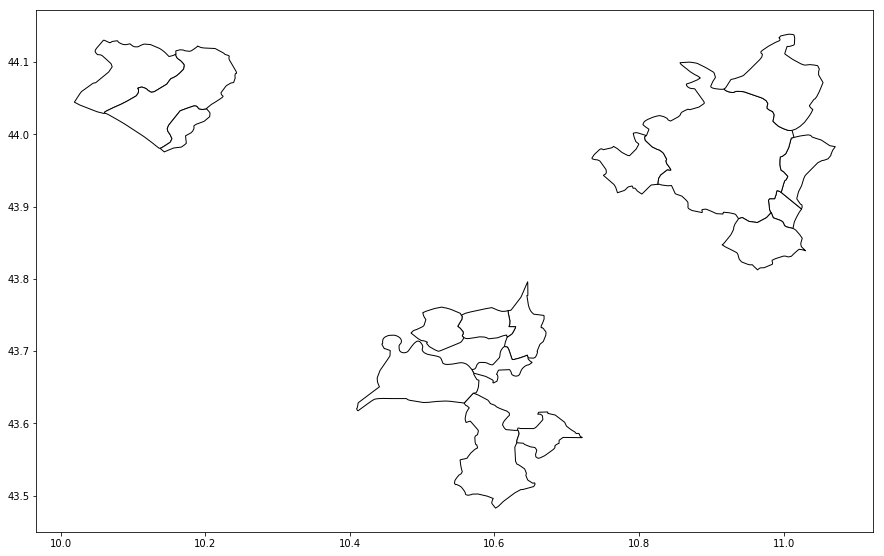

In [10]:
df_mun_tusc_sub.plot(color='white', edgecolor='k', figsize=(15, 15), alpha=1) # only borders


In [18]:
zero_with_loc_sub = zero_with_loc[zero_with_loc['lat']>42]

In [24]:
len(zero_with_loc_sub)

51074

In [22]:
oneHr_with_loc_sub = oneHr_with_loc[oneHr_with_loc['lat']>42]

In [25]:
len(oneHr_with_loc_sub)

151158

In [26]:
oneHr_with_loc_sub.head()

,location_id,customer_id,mcc,starttime,endtime,duration,minute,hour,day,customer_id,mcc,time_stamp,lat,lon,geom
0,59945033.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:28:00,43.7690,11.2954,0101000020E6100000107A36AB3E972640DF4F8D976EE2...
1,59945033.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:32:00,43.7690,11.2954,0101000020E6100000107A36AB3E972640DF4F8D976EE2...
2,59945033.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:29:00,43.7690,11.2954,0101000020E6100000107A36AB3E972640DF4F8D976EE2...
3,59945033.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:31:00,43.7690,11.2954,0101000020E6100000107A36AB3E972640DF4F8D976EE2...
4,59897012.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,2017-05-05 13:32:00,00:24:00,24.0,0.0,0.0,258BF569F91E57EE6F1B2311085B2F8B,262.0,2017-05-05 13:08:00,43.7922,11.2429,0101000020E6100000956588635D7C264013F241CF66E5...


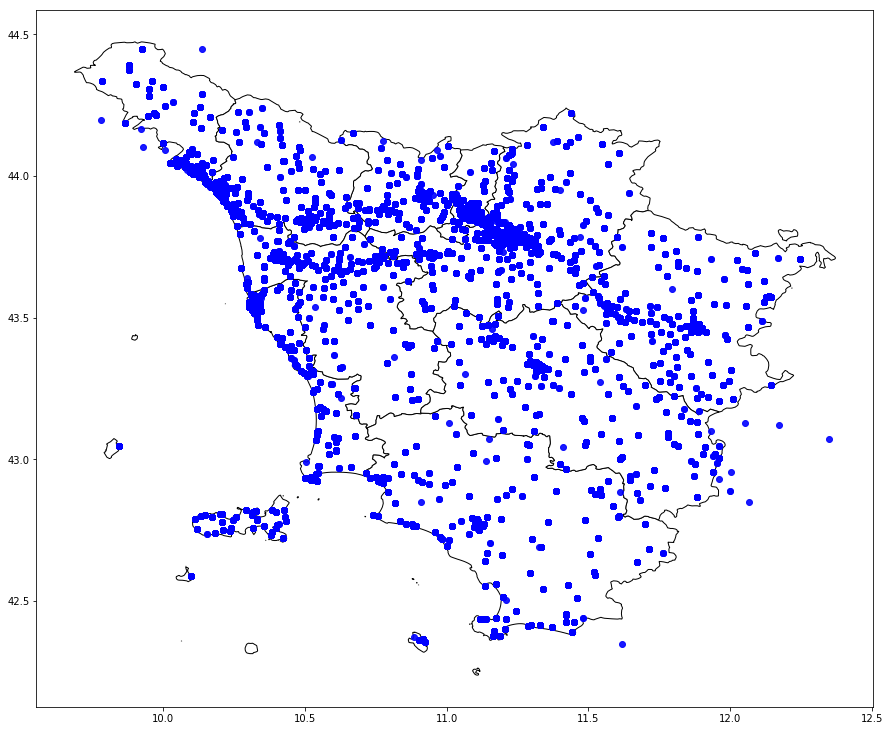

In [19]:
# Plot map with trajectories 

# df_tusc.plot(column="color_code", figsize=(15, 15)) # colorful fun map
df_tusc.plot(color='white', edgecolor='k', figsize=(15, 15), alpha=1) # only borders
# sns.despine()

# A random route beween Florence and Pisa 
#lats = oneHr_with_loc_sub.lon
#longs = oneHr_with_loc_sub.lat

lats = zero_with_loc_sub.lon
longs = zero_with_loc_sub.lat

plt.plot(lats, longs, 'o', color='b', alpha=0.9)
#plt.axis('off')
plt.show()

In [3]:
query_numloc_it = """select distinct customer_id, mcc, count(location_id) from tuscany_test.vodafone 
	group by customer_id, mcc order by count desc"""

In [21]:
query_numloc_tusc = """select distinct customer_id, mcc, count(cur_loc) from tuscany_test.vodafone_trunc
	group by customer_id, mcc order by count desc"""

In [4]:
numloc_it = db.sql_query_to_data_frame(query_numloc_it)

In [17]:
query_dist = """with choose_cus as (
 SELECT ROW_NUMBER() OVER(ORDER BY customer_id, time_stamp asc) AS RowNumber,
 customer_id,
 vod.location_id,
 loc.geom
from tpt.tuscany_test.vodafone as vod
inner join tpt.tuscany_test.location as loc
on loc.location_id=vod.location_id
) 

select 
cur.customer_id,
sum(ST_Distance(cur.geom::geography, prev.geom::geography)) as covered_distance
from choose_cus as cur
LEFT OUTER JOIN choose_cus as prev
ON cur.RowNumber = prev.RowNumber + 1
where cur.location_id != prev.location_id
	and cur.customer_id = prev.customer_id
group by cur.customer_id;"""

In [18]:
df_dist = db.sql_query_to_data_frame(query_dist)

In [19]:
df_numdist = numloc_it.set_index('customer_id').join(df_dist.set_index('customer_id'),rsuffix='_loc')
#df_numdist

,mcc,count,covered_distance
customer_id,,,
C4E85B682B2F57C41E8DC4B59300A4E0,248.0,9987,3.366401e+05
283DCCECA7D72B91B3C23C65462048AE,262.0,9583,3.333523e+05
1D55349B7669296EC09EA0FC9E5604FB,208.0,9307,2.912470e+06
C19A3119EB569BC9BA557E16F8D47065,262.0,6900,5.943127e+05
8A5F4E97DC34D6CC7D930C29F5E58030,716.0,6690,3.950668e+06
C9DF4955A7F0B474E71F8C9DE0CE58E9,204.0,6597,9.199907e+05
9480E955E68BEA1585B76B1CBDEF18ED,206.0,6223,9.922030e+07
7C2AF91EE50A926B97C0A0BD020DF505,262.0,5886,3.048107e+06
CE3C120422CCA7497BB0B81064B55B6D,204.0,5853,7.399321e+06


In [20]:
df_numdist.to_csv('/mnt/data/shared/numloc_distance_sample.csv')

In [ ]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [ ]:
for i in numloc['customer_id']:
    tmp=data[data['customer_id']==i]
    tmp=tmp.sort_values[by=['timestamp']]
    dist=0
    for ii in 1:len(tmp):
        disttmp=haversine()

In [23]:
numloc_tusc = db.sql_query_to_data_frame(query_numloc_tusc)

In [59]:
numloc_tusc.head()

,customer_id,mcc,count
0,8A5F4E97DC34D6CC7D930C29F5E58030,716.0,5499
1,C9DF4955A7F0B474E71F8C9DE0CE58E9,204.0,4977
2,EEA1A7DD4CC817B7D8AF71EDC52AD797,214.0,4551
3,9A194A3172907A067C0DF58F930AE86B,204.0,4528
4,F2CE1EDA2656B6A9394923CF05BD0BBA,214.0,4485


In [83]:
len(data_duration)

357614

In [85]:
len(numloc_it)

358503

In [86]:
len(numloc_tusc)

357614

In [89]:
dur_loc = numloc_it.set_index('customer_id').join(data_duration.set_index('customer_id'), rsuffix='_dur', how='right')

In [90]:
len(dur_loc)

357614

In [91]:
dur_loc2 = dur_loc.join(numloc_tusc.set_index('customer_id'), rsuffix='_tusc', how='right')

In [92]:
len(dur_loc2)

357614

In [93]:
dur_loc2.head()

,mcc,count,mcc_dur,starttime,endtime,duration,mcc_tusc,count_tusc
customer_id,,,,,,,,
8A5F4E97DC34D6CC7D930C29F5E58030,716.0,6690,716.0,2017-05-01 00:01:00,2017-05-07 23:58:00,6 days 23:57:00,716.0,5499
C9DF4955A7F0B474E71F8C9DE0CE58E9,204.0,6597,204.0,2017-05-01 00:00:00,2017-05-07 23:58:00,6 days 23:58:00,204.0,4977
EEA1A7DD4CC817B7D8AF71EDC52AD797,214.0,4949,214.0,2017-05-01 14:48:00,2017-05-07 23:58:00,6 days 09:10:00,214.0,4551
9A194A3172907A067C0DF58F930AE86B,204.0,5659,204.0,2017-05-01 00:00:00,2017-05-07 23:50:00,6 days 23:50:00,204.0,4528
F2CE1EDA2656B6A9394923CF05BD0BBA,214.0,5100,214.0,2017-05-01 00:00:00,2017-05-07 23:58:00,6 days 23:58:00,214.0,4485


In [94]:
dur_loc2['tusc_vs_it'] = dur_loc2['count_tusc']/dur_loc2['count']*100

In [95]:
dur_loc2.tusc_vs_it.describe()

count    357614.000000
mean         53.620275
std          32.325298
min           0.064309
25%          25.641026
50%          50.000000
75%          81.481481
max         100.000000
Name: tusc_vs_it, dtype: float64

In [96]:
dur_loc2.sort_values(by=['tusc_vs_it'],  ascending=False)

,mcc,count,mcc_dur,starttime,endtime,duration,mcc_tusc,count_tusc,tusc_vs_it
customer_id,,,,,,,,,
3B77AF7C5E64023FA6D13B16875BB9ED,214.0,2,214.0,2017-05-05 17:31:00,2017-05-05 17:32:00,0 days 00:01:00,214.0,2,100.000000
B684ED2B5F0B107D14A36FAE7303719F,502.0,2,502.0,2017-05-01 13:01:00,2017-05-01 20:05:00,0 days 07:04:00,502.0,2,100.000000
B588CB1A04CF9A6233C67D852133A615,214.0,2,214.0,2017-05-06 15:30:00,2017-05-06 21:17:00,0 days 05:47:00,214.0,2,100.000000
B5900AD4B785233C2D773B11EBD5C2F2,255.0,2,255.0,2017-05-03 17:54:00,2017-05-04 14:34:00,0 days 20:40:00,255.0,2,100.000000
B59FD5F047B377D5E4E9B3C76E7C5B4F,234.0,2,234.0,2017-05-05 11:08:00,2017-05-05 13:44:00,0 days 02:36:00,234.0,2,100.000000
B5A177BC022DCBF83A5AD8C27FEA8FDD,310.0,2,310.0,2017-05-02 08:57:00,2017-05-02 08:58:00,0 days 00:01:00,310.0,2,100.000000
B5AA7C6CE59E68750592CC4F4D47A449,260.0,2,260.0,2017-05-01 19:08:00,2017-05-01 20:55:00,0 days 01:47:00,260.0,2,100.000000
B5AB756D2221392B03980E54828C712D,255.0,2,255.0,2017-05-06 16:41:00,2017-05-07 10:38:00,0 days 17:57:00,255.0,2,100.000000
B5BBA431EEFCD894F3609EA247015C58,460.0,2,460.0,2017-05-07 08:34:00,2017-05-07 14:27:00,0 days 05:53:00,460.0,2,100.000000


In [101]:
dur_loc2.count_tusc.max()

5499

/home/ywang99587/.conda/envs/tptyw/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


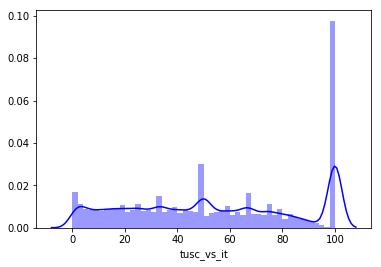

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns


# seaborn histogram
sns.distplot(dur_loc2['tusc_vs_it'], hist=True, kde=True, 
             color = 'blue')

Text(0,1,'Ratio of locations visited in Tuscnay over Italy')

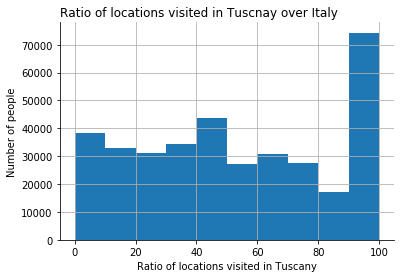

In [100]:
dur_loc2['tusc_vs_it'].hist()
sns.despine()
plt.ylabel("Number of people")
plt.xlabel("Ratio of locations visited in Tuscany")
plt.title("Ratio of locations visited in Tuscnay over Italy", loc='left')

In [102]:
ratio_of_locs_tusc=[]
for i in range(0,5499):
    ratio_of_locs_tusc.append(len(dur_loc2[dur_loc2['count_tusc']<i])/len(dur_loc2))

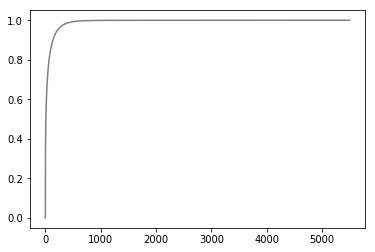

In [104]:
plt.plot(range(0,5499),ratio_of_locs_tusc[:5499], color="grey")